In [ ]:
## Enviroment Setup
import os, sys
#WORKING_DIR = '/home/peizhi/Documents/flame-head-tracker'
WORKING_DIR = '/mnt/data5_hdd/haoyu/flame-head-tracker'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

sys.path.append(WORKING_DIR)
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/flame_fitting/')
sys.path.append('./utils/face_parsing/')
sys.path.append('./utils/decalib/')
sys.path.append('./utils/mesh_renderer')
sys.path.append('./utils/scene')

import matplotlib.pyplot as plt
import numpy as np
import cv2

from tracker_base import Tracker

from utils.graphics_utils import create_diff_world_to_view_matrix, verts_clip_to_ndc
from utils.scene.cameras import PerspectiveCamera
from utils.mesh_renderer import NVDiffRenderer



Current Working Directory:  /mnt/data5_hdd/haoyu/flame-head-tracker
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

###########################
## Setup Flame Tracker    #     
###########################

tracker_cfg = {
    'mediapipe_face_landmarker_v2_path': './models/face_landmarker_v2_with_blendshapes.task',
    'flame_model_path': './models/FLAME2020/generic_model.pkl',
    'flame_lmk_embedding_path': './models/landmark_embedding.npy',
    'tex_space_path': './models/FLAME_texture.npz',
    'face_parsing_model_path': './utils/face_parsing/79999_iter.pth',
    'uv_coord_mapping_file_path': './models/uv2vert_256.npy',
    'template_mesh_file_path': './models/head_template.obj',
    'result_img_size': 512,
    'device': device,
}

tracker = Tracker(tracker_cfg)



I0000 00:00:1730761337.859003 4030912 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1730761337.882721 4031325 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.120), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1730761337.883336 4030912 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730761337.892751 4031329 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730761337.925452 4031345 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


creating the FLAME Decoder


/mnt/data5_hdd/haoyu/flame-head-tracker/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/mnt/data5_hdd/haoyu/flame-head-tracker/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/haoyu/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/haoyu/miniconda3

creating the FLAME Decoder
trained model found. load models/deca_model.tar
Flame Tracker ready.


/home/haoyu/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


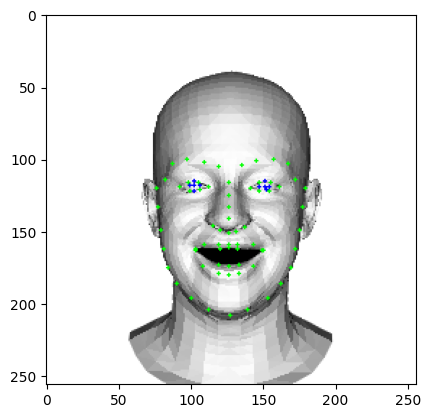

In [16]:


shape = np.zeros([1,100], dtype=np.float32)
exp = np.zeros([1,50], dtype=np.float32)
pose = np.zeros([1,6], dtype=np.float32)
eye_pose = np.zeros([1,6], dtype=np.float32)
cam_pose = np.array([0,0,0,0,0,1.0], dtype=np.float32)


# load from file
params = np.load('/mnt/data4_hdd/share/synthetic-FaceTalk/id-0_tracking-data/FaceTalk_170725_00137_TA/bareteeth/images/0025.npy', allow_pickle=True)
exp = params['exp']
pose = params['pose']
eye_pose = params['eye_pose']
cam_pose = params['cam']
cam_pose[-1] = 1.0 # I manually move the head closer to the camera


with torch.no_grad():
    
    # Prepare Tensors
    shape = torch.from_numpy(shape).to(device)
    exp = torch.from_numpy(exp).to(device)
    pose = torch.from_numpy(pose).to(device)
    eye_pose = torch.from_numpy(eye_pose).to(device)
    cam_pose = torch.from_numpy(cam_pose).to(device)

    # FLAME Reconstruction
    vertices, _, _ = tracker.flame(shape_params=shape, expression_params=exp, pose_params=pose, eye_pose_params=eye_pose)

    # Prepare Camera
    Rt = create_diff_world_to_view_matrix(cam_pose)
    cam = PerspectiveCamera(Rt=Rt, fov=tracker.fov, bg=tracker.bg_color, 
                            image_width=tracker.W, image_height=tracker.H, znear=tracker.znear, zfar=tracker.zfar)

    # Render
    new_mesh_renderer = NVDiffRenderer().to(tracker.device) # there seems to be a bug with the NVDiffRenderer, so I create this new
                                                            # render everytime to render the image
    rendered = new_mesh_renderer.render_from_camera(vertices, tracker.mesh_faces, cam) # vertices should have the shape of [1, N, 3]
    verts_clip = rendered['verts_clip'] # [1, N, 3]
    verts_ndc_3d = verts_clip_to_ndc(verts_clip, image_size=tracker.H, out_dim=3) # convert the clipped vertices to NDC, output [N, 3]
    landmarks3d = tracker.flame.seletec_3d68(verts_ndc_3d[None]) # [1, 68, 3]
    landmarks2d = landmarks3d[:,:,:2].detach().cpu().numpy() # [1, 68, 2]
    eyes_landmarks3d = verts_ndc_3d[tracker.R_EYE_INDICES + tracker.L_EYE_INDICES][None]  # [1, 10, 3]
    eyes_landmarks2d = eyes_landmarks3d[:,:,:2].detach().cpu().numpy()  # [1, 10, 2]
    rendered_mesh_shape = rendered['rgba'][0,...,:3].detach().cpu().numpy()
    rendered_mesh_shape = np.array(np.clip(rendered_mesh_shape * 255, 0, 255), dtype=np.uint8) # uint8

    # Draw 2D landmarks as green dots
    for coords in landmarks2d[0]:
        coords = np.clip(coords, 0, tracker.H).astype(np.uint8)
        #coords = np.clip((coords / 2 + 1) * self.H, 0, self.H).astype(np.uint8)
        cv2.circle(rendered_mesh_shape, (coords[0], coords[1]), radius=1, color=(0, 255, 0), thickness=-1)  # Green color, filled circle

    # Optionally draw eye landmarks as red dots
    for coords in eyes_landmarks2d[0]:
        coords = np.clip(coords, 0, tracker.H).astype(np.uint8)
        #coords = np.clip((coords / 2 + 1) * self.H, 0, self.H).astype(np.uint8)
        cv2.circle(rendered_mesh_shape, (coords[0], coords[1]), radius=1, color=(0, 0, 255), thickness=-1)  # Red color, filled circle

    plt.imshow(rendered_mesh_shape)
    plt.show()

    
